# Usage

In [1]:
from hydrodata import Dataloader

Hydrodata module downloads daily climate data for a USGS station based its ID or coordinates (longitude and latitude). It requires at least three parameters: start date, end date and USGS station ID or coordinates. The data are downloaded from the [Daymet](https://daymet.ornl.gov/) and [NWIS](https://nwis.waterdata.usgs.gov/nwis) datasets.

## Climate Data

For example, let's consider the following USGS station:

In [2]:
start, end = '2000-01-01', '2015-12-31'
station_id = '01467087'
gis_dir = '../examples/gis_data'
data_dir = '../examples/data'

Now, we can define an instance based on the station ID. Upon instantiation, the station and its watershed characteristics are found using [StreamStats](https://www.usgs.gov/mission-areas/water-resources/science/streamstats-streamflow-statistics-and-spatial-analysis-tools?qt-science_center_objects=0#qt-science_center_objects) service.

In [3]:
frankford = Dataloader(start,
                       end,
                       station_id=station_id,
                       gis_dir=gis_dir,
                       data_dir=data_dir)

The watershed parameters saved to ../examples/data/02040202/parameters.json
The watershed geometry was saved to ../examples/gis_data/02040202/geometry.shp
The station is located in the Frankford Creek at Castor Ave, Philadelphia, PA watershed


Some of the watershed characteristics are saved as `json` file in the data directory. The `wshed_params` variable contains all the available data and an individual characteristic can be accesed via `get_characteristic` function, for example:

In [4]:
frankford.get_characteristic('STRMTOT')

{'ID': 0,
 'name': 'Stream Length Total',
 'description': 'total length of all mapped streams (1:24,000-scale) in the basin',
 'code': 'STRMTOT',
 'unit': 'miles',
 'value': 24.54}

Note that a list of all the available codes are displayed when the function called without any argument, `frankford.get_characteristic()`.

The climate data can be downloaded using `get_climate` function. The data is downloaded and saved as an HDF5 file. If the file exists, it is read from the disk.

In [5]:
frankford.get_climate()

Computing potential evapotranspiration (PET) using FAO method
climate data was downloaded successfuly and saved to ../examples/data/02040202/20000101_20151231.h5


The data is returned as a `pandas` dataframe.

In [6]:
frankford.climate.head()

prcp (mm/day)  tmin (C)  tmax (C)  tmean (C)  pet (mm)  qobs (cms)
2000-01-01            0.0      -2.5       8.5        3.0      0.95    0.453070
2000-01-02            0.0       1.5      16.5        9.0      1.55    0.453070
2000-01-03            0.0       8.5      17.5       13.0      1.23    0.453070
2000-01-04           18.0       9.0      19.0       14.0      1.39    4.955448
2000-01-05            0.0       0.0      13.0        6.5      1.32    1.387525

Hydrodata has a function called `separate_snow` for separating snow and rain from the total precipitation.

In [7]:
df = frankford.climate.copy()
df["pr (mm/day)"], df["ps (mm/day)"] = frankford.separate_snow(
    df["prcp (mm/day)"].values,
    df["tmean (C)"].values,
    tcr=0)
df.head()

prcp (mm/day)  tmin (C)  tmax (C)  tmean (C)  pet (mm)  \
2000-01-01            0.0      -2.5       8.5        3.0      0.95   
2000-01-02            0.0       1.5      16.5        9.0      1.55   
2000-01-03            0.0       8.5      17.5       13.0      1.23   
2000-01-04           18.0       9.0      19.0       14.0      1.39   
2000-01-05            0.0       0.0      13.0        6.5      1.32   

            qobs (cms)  pr (mm/day)  ps (mm/day)  
2000-01-01    0.453070          0.0          0.0  
2000-01-02    0.453070          0.0          0.0  
2000-01-03    0.453070          0.0          0.0  
2000-01-04    4.955448         18.0          0.0  
2000-01-05    1.387525          0.0          0.0

Moreover, longitude and latitude coordinate can also be used for downloading the data. The coordinates doesn't have to be exact since the closest station to the specified coordinates is found automatically. For example, let's find the climate data for a station close to longitude -76.43 and latitude of 41.08.

In [8]:
fishing = Dataloader(start,
                     end,
                     coords=(-76.43, 41.08),
                     gis_dir=gis_dir,
                     data_dir=data_dir)
fishing.get_climate()

The watershed parameters saved to ../examples/data/02050107/parameters.json
The watershed geometry was saved to ../examples/gis_data/02050107/geometry.shp
The station is located in the Fishing Creek near Bloomsburg, PA watershed
Computing potential evapotranspiration (PET) using FAO method
climate data was downloaded successfuly and saved to ../examples/data/02050107/20000101_20151231.h5


## Land Use, Land Cover Data

The `get_nlcd` function can be used to download land use, land cover (LULC), canopy and impervious data from the National Land Cover Database (NLCD) 2016 dataset. The data are saved as a `geotiff` file and are read from the disk if it's downloaded previously.

In [9]:
years = {'impervious': 2011, 'cover': 2011, 'canopy': 2011}
frankford.get_nlcd(years=years)

impervious data was downloaded successfuly and saved to ../examples/data/02040202/impervious_2011.geotiff
cover data was downloaded successfuly and saved to ../examples/data/02040202/cover_2011.geotiff


/home/taher/.local/apps/miniconda/envs/hydrodata/lib/python3.8/site-packages/rasterio/mask.py:193: NodataShadowWarning: The dataset's nodata attribute is shadowing the alpha band. All masks will be determined by the nodata attribute
  out_image = dataset.read(


canopy data was downloaded successfuly and saved to ../examples/data/02040202/canopy_2011.geotiff


The downloaded files can be plotted using `rasterio`.

In [10]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt

/home/taher/.local/apps/miniconda/envs/hydrodata/lib/python3.8/site-packages/rasterio/plot.py:109: NodataShadowWarning: The dataset's nodata attribute is shadowing the alpha band. All masks will be determined by the nodata attribute
  arr = source.read(rgb_indexes, masked=True)


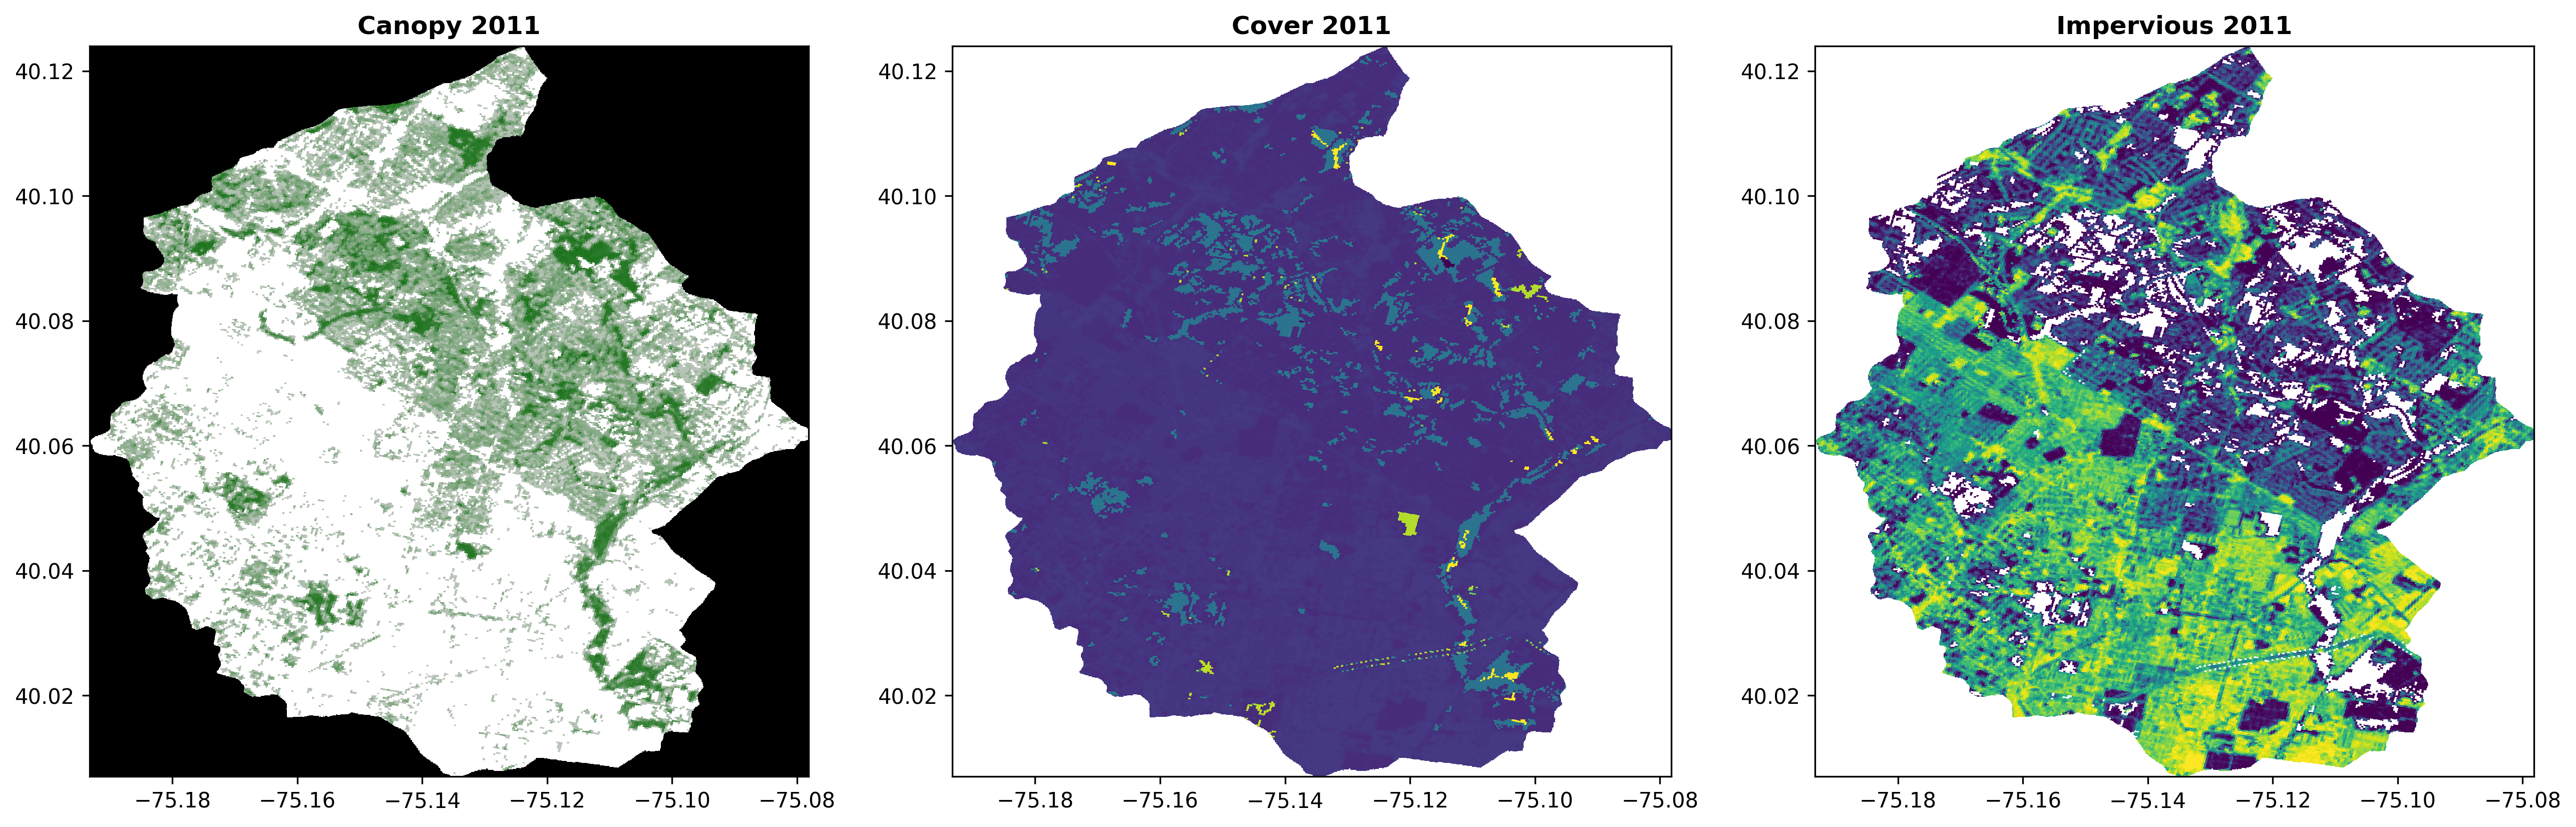

In [11]:
canopy = rasterio.open(frankford.data_dir.joinpath(f'canopy_{years["canopy"]}.geotiff'), masked=True)
cover = rasterio.open(frankford.data_dir.joinpath(f'cover_{years["cover"]}.geotiff'), masked=True)
impervious = rasterio.open(frankford.data_dir.joinpath(f'impervious_{years["impervious"]}.geotiff'), masked=True)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(21, 7), dpi=300)
show(canopy, ax=ax1, title=f'Canopy {years["canopy"]}')
show(cover, ax=ax2, title=f'Cover {years["cover"]}')
show(impervious, ax=ax3, title=f'Impervious {years["impervious"]}')
fig.savefig('NLCD.png', dpi=300, bbox_inches="tight");

For the land use, land cover data `cover_stats` function can be used to compute percentages of cover [class and categories](https://www.mrlc.gov/data/legends/national-land-cover-database-2016-nlcd2016-legend).

In [12]:
class_percentage, category_percentage = frankford.cover_stats()

In [13]:
class_percentage

{'Unclassified': 38.859896602658786,
 'Open Water': 0.017676021664204823,
 'Perennial Ice/Snow': 0.0,
 'Developed, Open Space': 16.536706056129987,
 'Developed, Low Intensity': 13.352708025603151,
 'Developed, Medium Intensity': 17.600590841949778,
 'Developed High Intensity': 8.25108321024126,
 'Barren Land (Rock/Sand/Clay)': 0.02117183653372723,
 'Deciduous Forest': 3.968734613490891,
 'Evergreen Forest': 0.0017725258493353029,
 'Mixed Forest': 0.8779665189561793,
 'Dwarf Scrub': 0.0,
 'Shrub/Scrub': 0.01981782373215165,
 'Grassland/Herbaceous': 0.02346134908911866,
 'Sedge/Herbaceous': 0.0,
 'Lichens': 0.0,
 'Moss': 0.0,
 'Pasture/Hay': 0.15800098473658297,
 'Cultivated Crops': 0.0709010339734121,
 'Woody Wetlands': 0.2106351550960118,
 'Emergent Herbaceous Wetlands': 0.0}

In [14]:
category_percentage

{'Unclassified': 38.859896602658786,
 'Water': 0.017676021664204823,
 'Developed': 55.74108813392418,
 'Barren': 0.02117183653372723,
 'Forest': 4.848473658296406,
 'Shrubland': 0.01981782373215165,
 'Herbaceous': 0.02346134908911866,
 'Planted/Cultivated': 0.22890201870999508,
 'Wetlands': 0.2106351550960118}

## Plotting

The hydrologic signatures can be plotted easily using the `plot` and `plot_discharge` functions. These functions convert the streamflow data from cubic meter per second to millimeter per day based on the watershed area which should be provided in km$^2$. The function are written with three use cases in mind that are demonstrated below.

### Observed discharge for a station

In this case, the `plot` function can simply be called for any Hydrodata instance with just one optional argument for saving the plot as a `png` image.

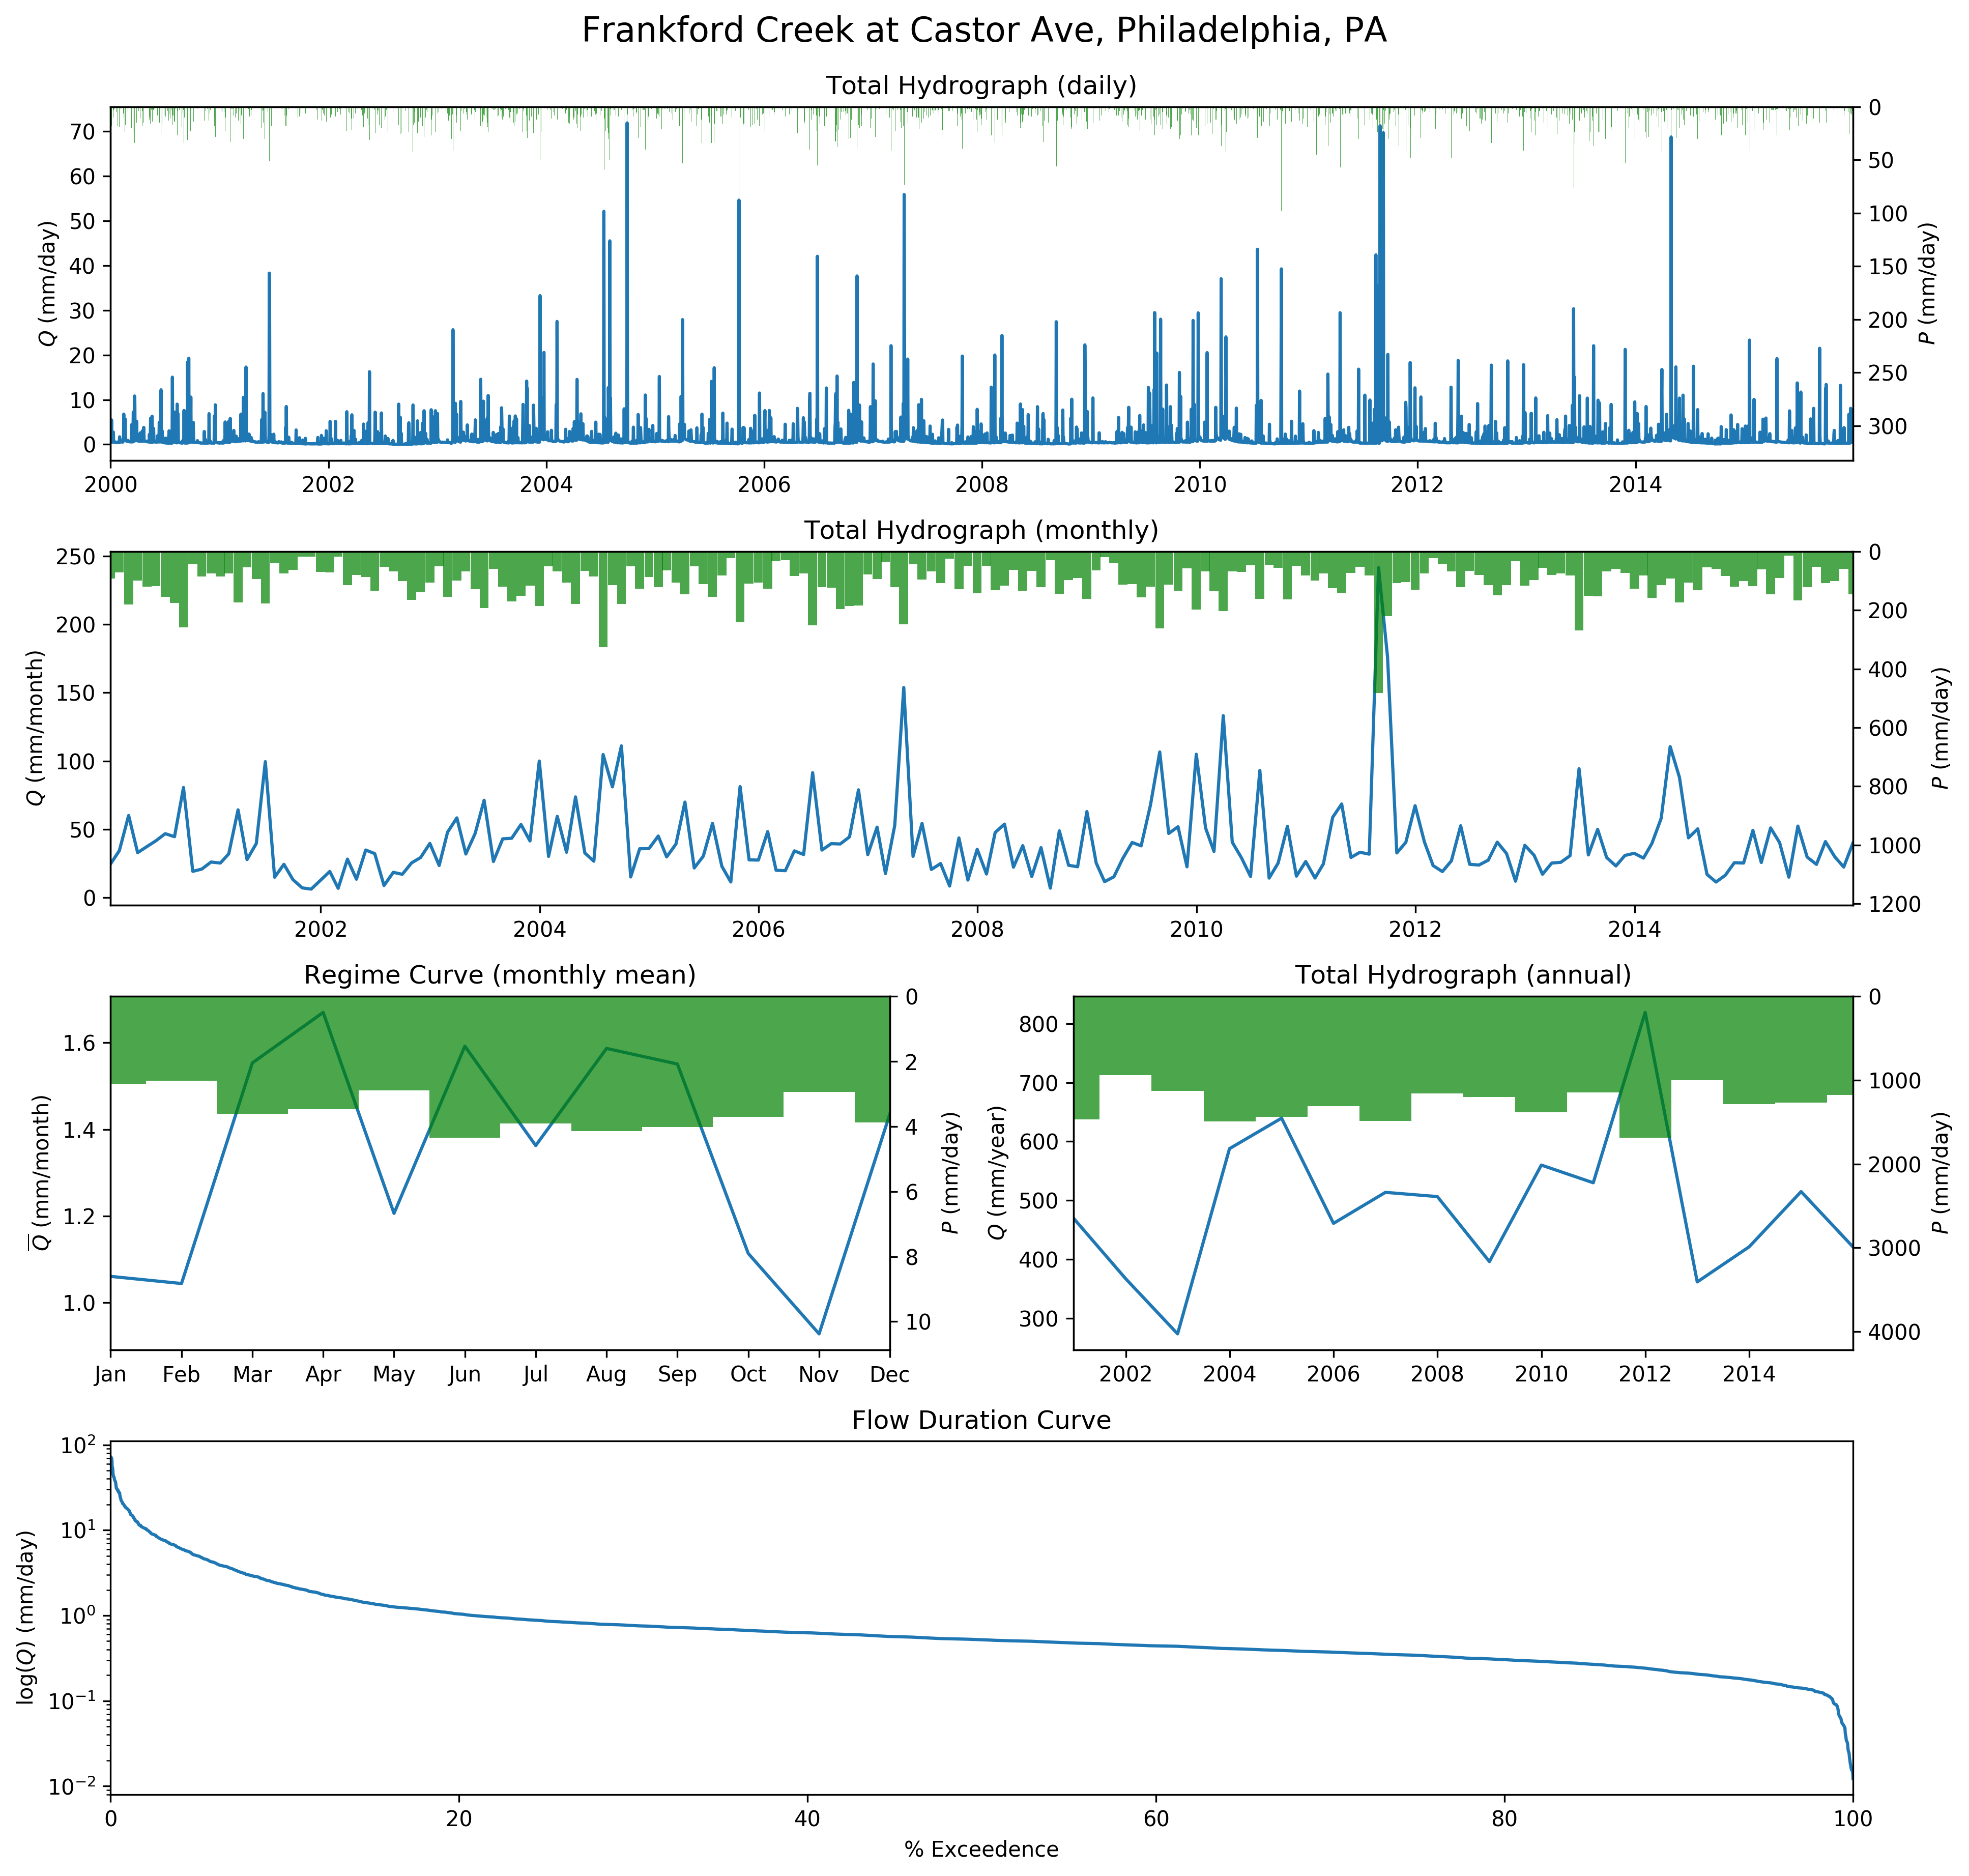

In [15]:
frankford.plot(output=f'Observed_{frankford.station_id}.png')

### Observed and simulated discharges for a station

In this case, the observed and simulation data are to be compared. For example, let's use [RRMPG](https://rrmpg.readthedocs.io/en/latest/) package to model the watershed using a lumped model called [CemaneigeGR4J](https://rrmpg.readthedocs.io/en/latest/api/models.html#cemaneigegr4j). This Python package can be installed as follows. Open up a terminal and change directory to a location for cloning the [RRMPG](https://github.com/kratzert/RRMPG) Github repository:
```bash
cd repos
git clone https://github.com/kratzert/RRMPG.git
cd RRMPG
```
Then load the Anaconda environment that Hydrodata is installed, for example `hydrodata`, and install RRMPG:
```bash
conda activate hydrodata
python setup.py install
conda install scipy
```
Now we can run two simulations for the Frankford watershed and use two methods for calibrating the model: Differential Evolution and Monte Carlo.

In [16]:
from rrmpg.models import CemaneigeGR4J
from rrmpg.tools.monte_carlo import monte_carlo
import pandas as pd
import numpy as np

In [17]:
# Split the climate data for calibration and validation
start = frankford.climate.index[0]
end = frankford.climate.index[-1]
cal_size = 70.0  # percentage of data to be used for calibration

cal_period = np.ceil((end.year - start.year) * cal_size / 100.0)
cal_end = start + pd.DateOffset(years=cal_period + 1) - pd.DateOffset(days=1)
cal = frankford.climate[:cal_end].copy()  # calibration dataframe
val = frankford.climate[cal_end:].copy()  # validation dataframe

# Differential Evolution calibration
model_diff = CemaneigeGR4J()
result_fit = model_diff.fit(cal['qobs (cms)'], cal['prcp (mm/day)'], cal['tmean (C)'],
                            cal['tmin (C)'], cal['tmax (C)'], cal['pet (mm)'],
                            frankford.datum)
Q_diff = model_diff.simulate(val['prcp (mm/day)'], val['tmean (C)'],
                             val['tmin (C)'], val['tmax (C)'], val['pet (mm)'],
                             frankford.datum).flatten()

# Monte Calro calibration
model_mc = CemaneigeGR4J()
result_mc = monte_carlo(model_mc, num=10000, qobs=cal['qobs (cms)'], 
                        prec=cal['prcp (mm/day)'], mean_temp=cal['tmean (C)'],
                        min_temp=cal['tmin (C)'], max_temp=cal['tmax (C)'],
                        etp=cal['pet (mm)'], met_station_height=frankford.datum)
Q_mc = model_mc.simulate(val['prcp (mm/day)'], val['tmean (C)'],
                         val['tmin (C)'], val['tmax (C)'], val['pet (mm)'],
                         frankford.datum).flatten()

The two methods can be compared with the observed data using the `plot` function. An additional argument, `Q_dict`, needs to be provided that contains the discharge data as a dictionary. The keys of this dictionary are the labels (plot legends) and the values are time series of the observed and simulated data. The function can handle multiple discharges.

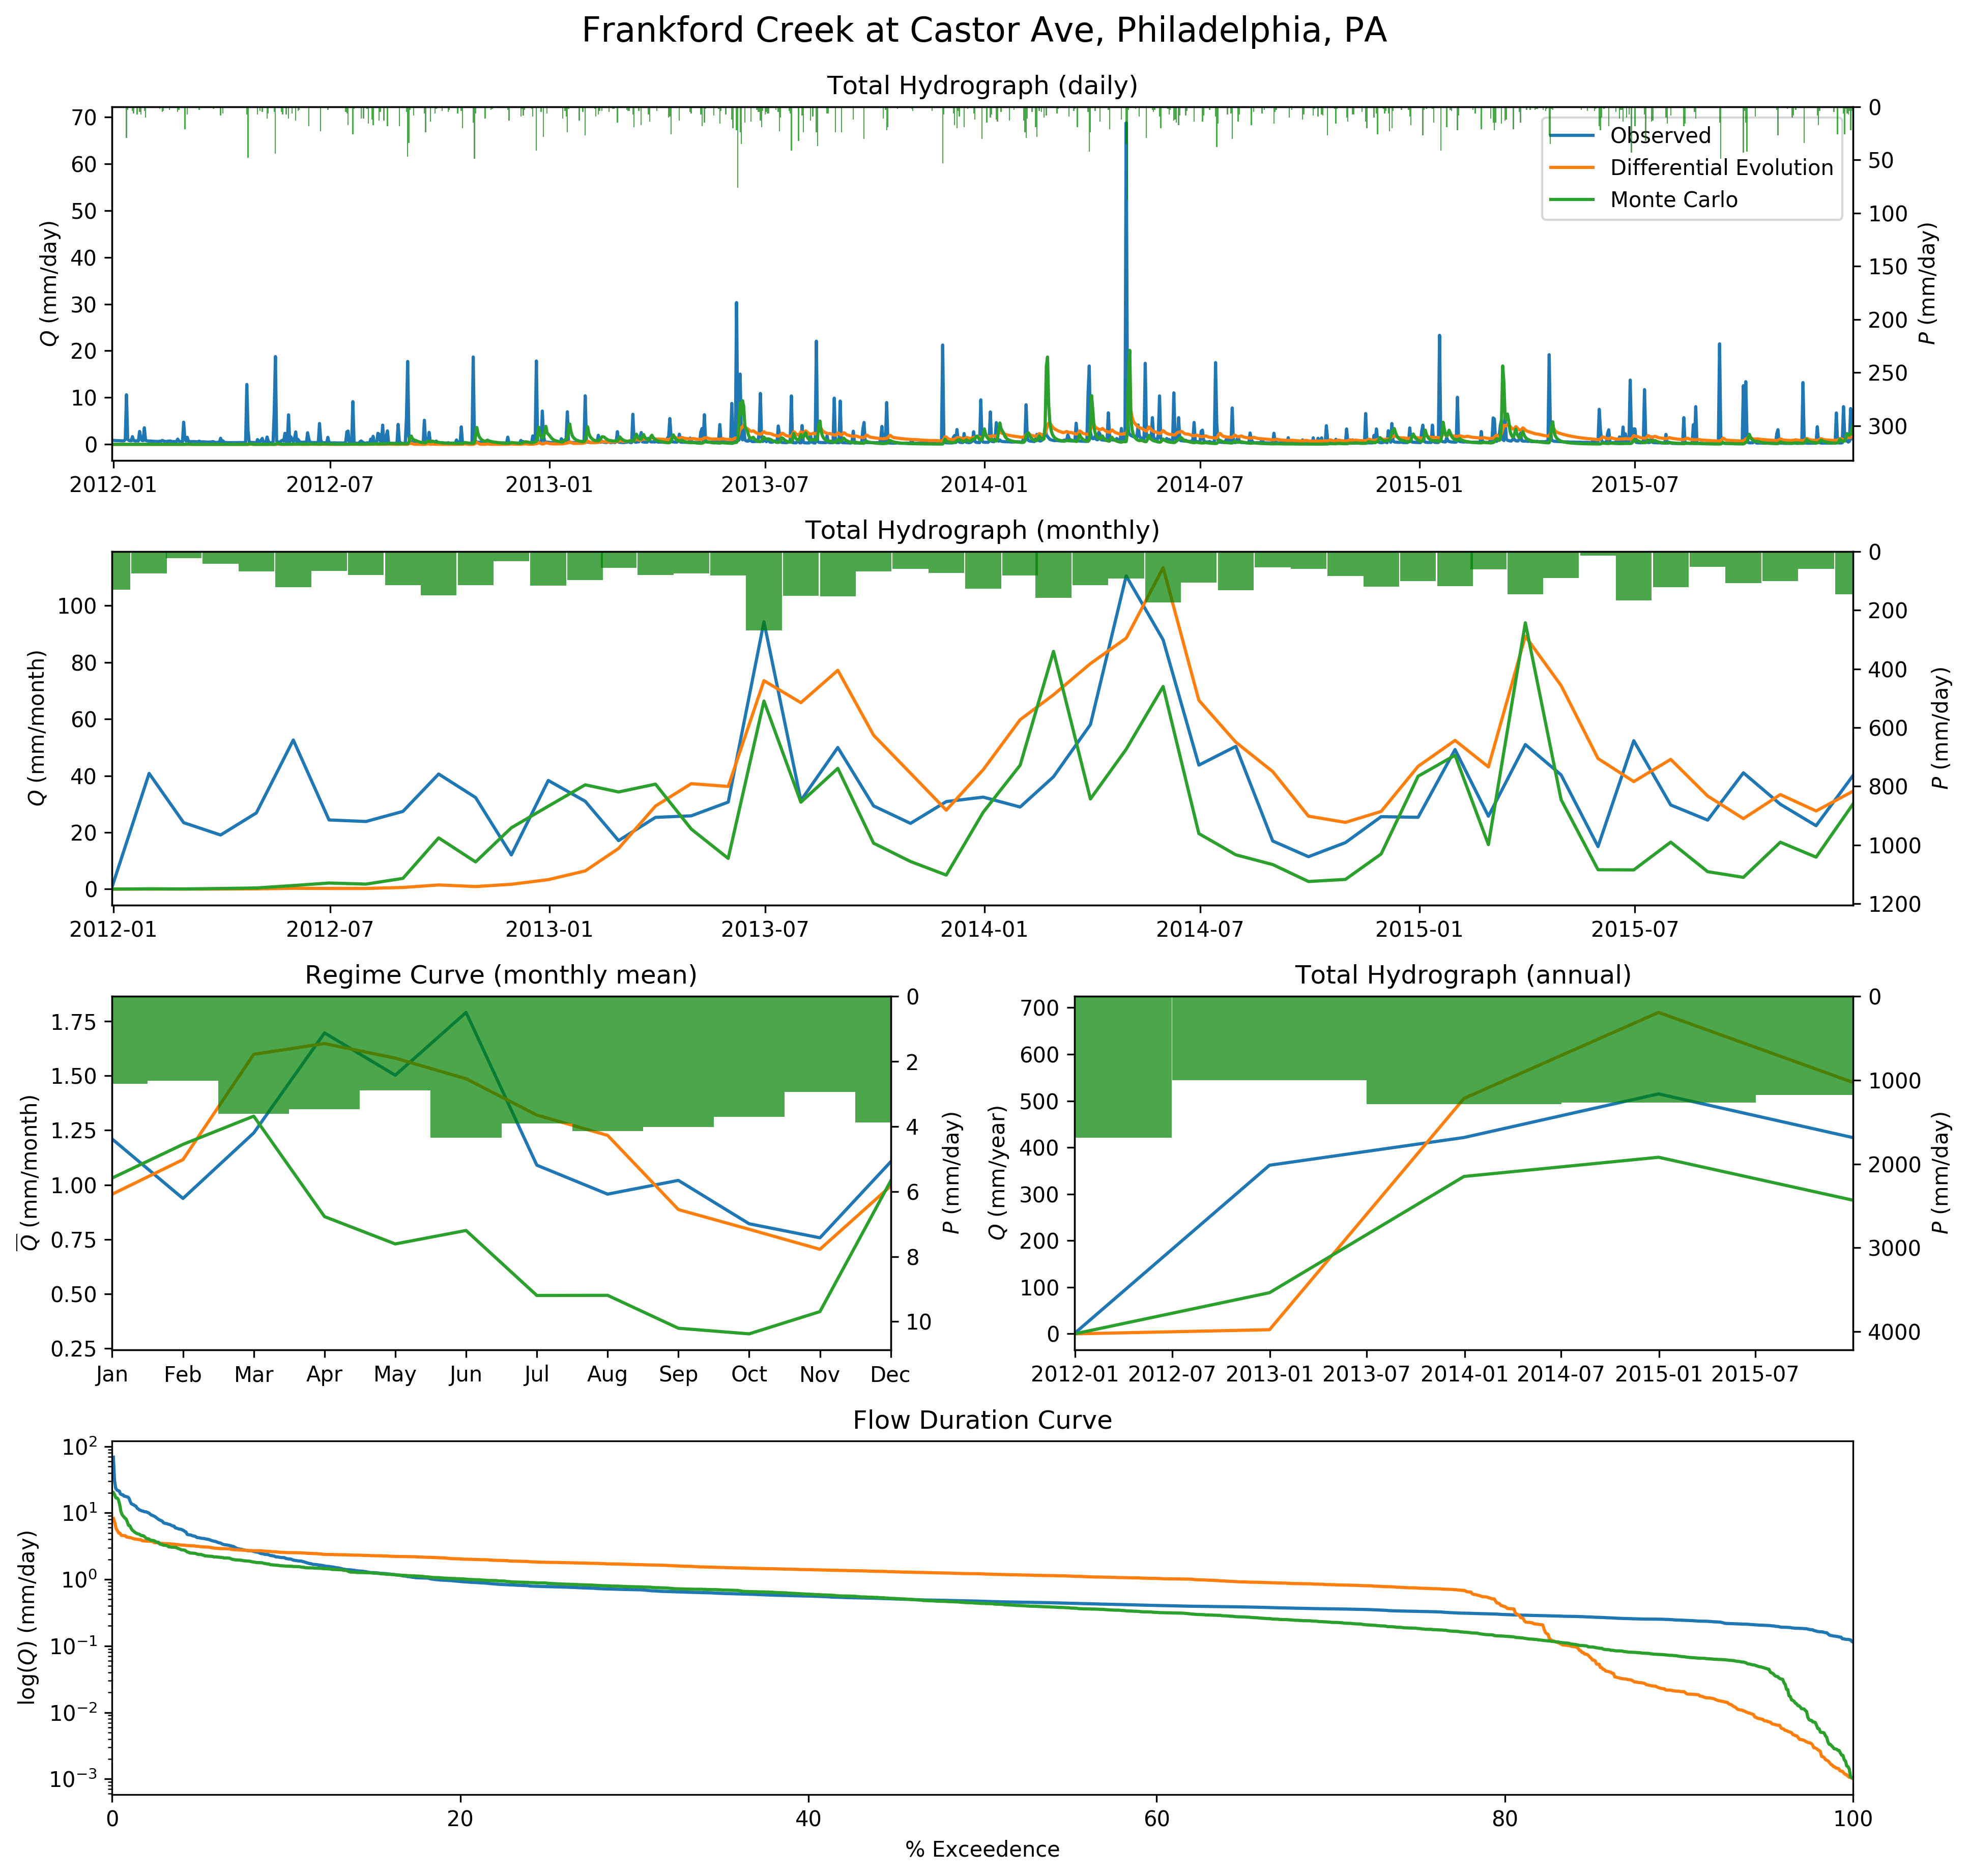

In [18]:
Q_dict = {'Observed': frankford.climate.loc[val.index, 'qobs (cms)'],
          'Differential Evolution': pd.Series(Q_diff, index=val.index),
          'Monte Carlo': pd.Series(Q_mc, index=val.index)}
frankford.plot(Q_dict=Q_dict, output=f'Simulated_{frankford.station_id}.png')

### Observed discharge for multiple stations

The `plot_discharge` function can be used to compare hydrological signatures of multiple daily discharges time series of multiple stations. This plot doesn't include the precipitation data and only compares the discharges. Let's compare the Frankford and Fishing watershed. The discharge dictionary should be provided as before.

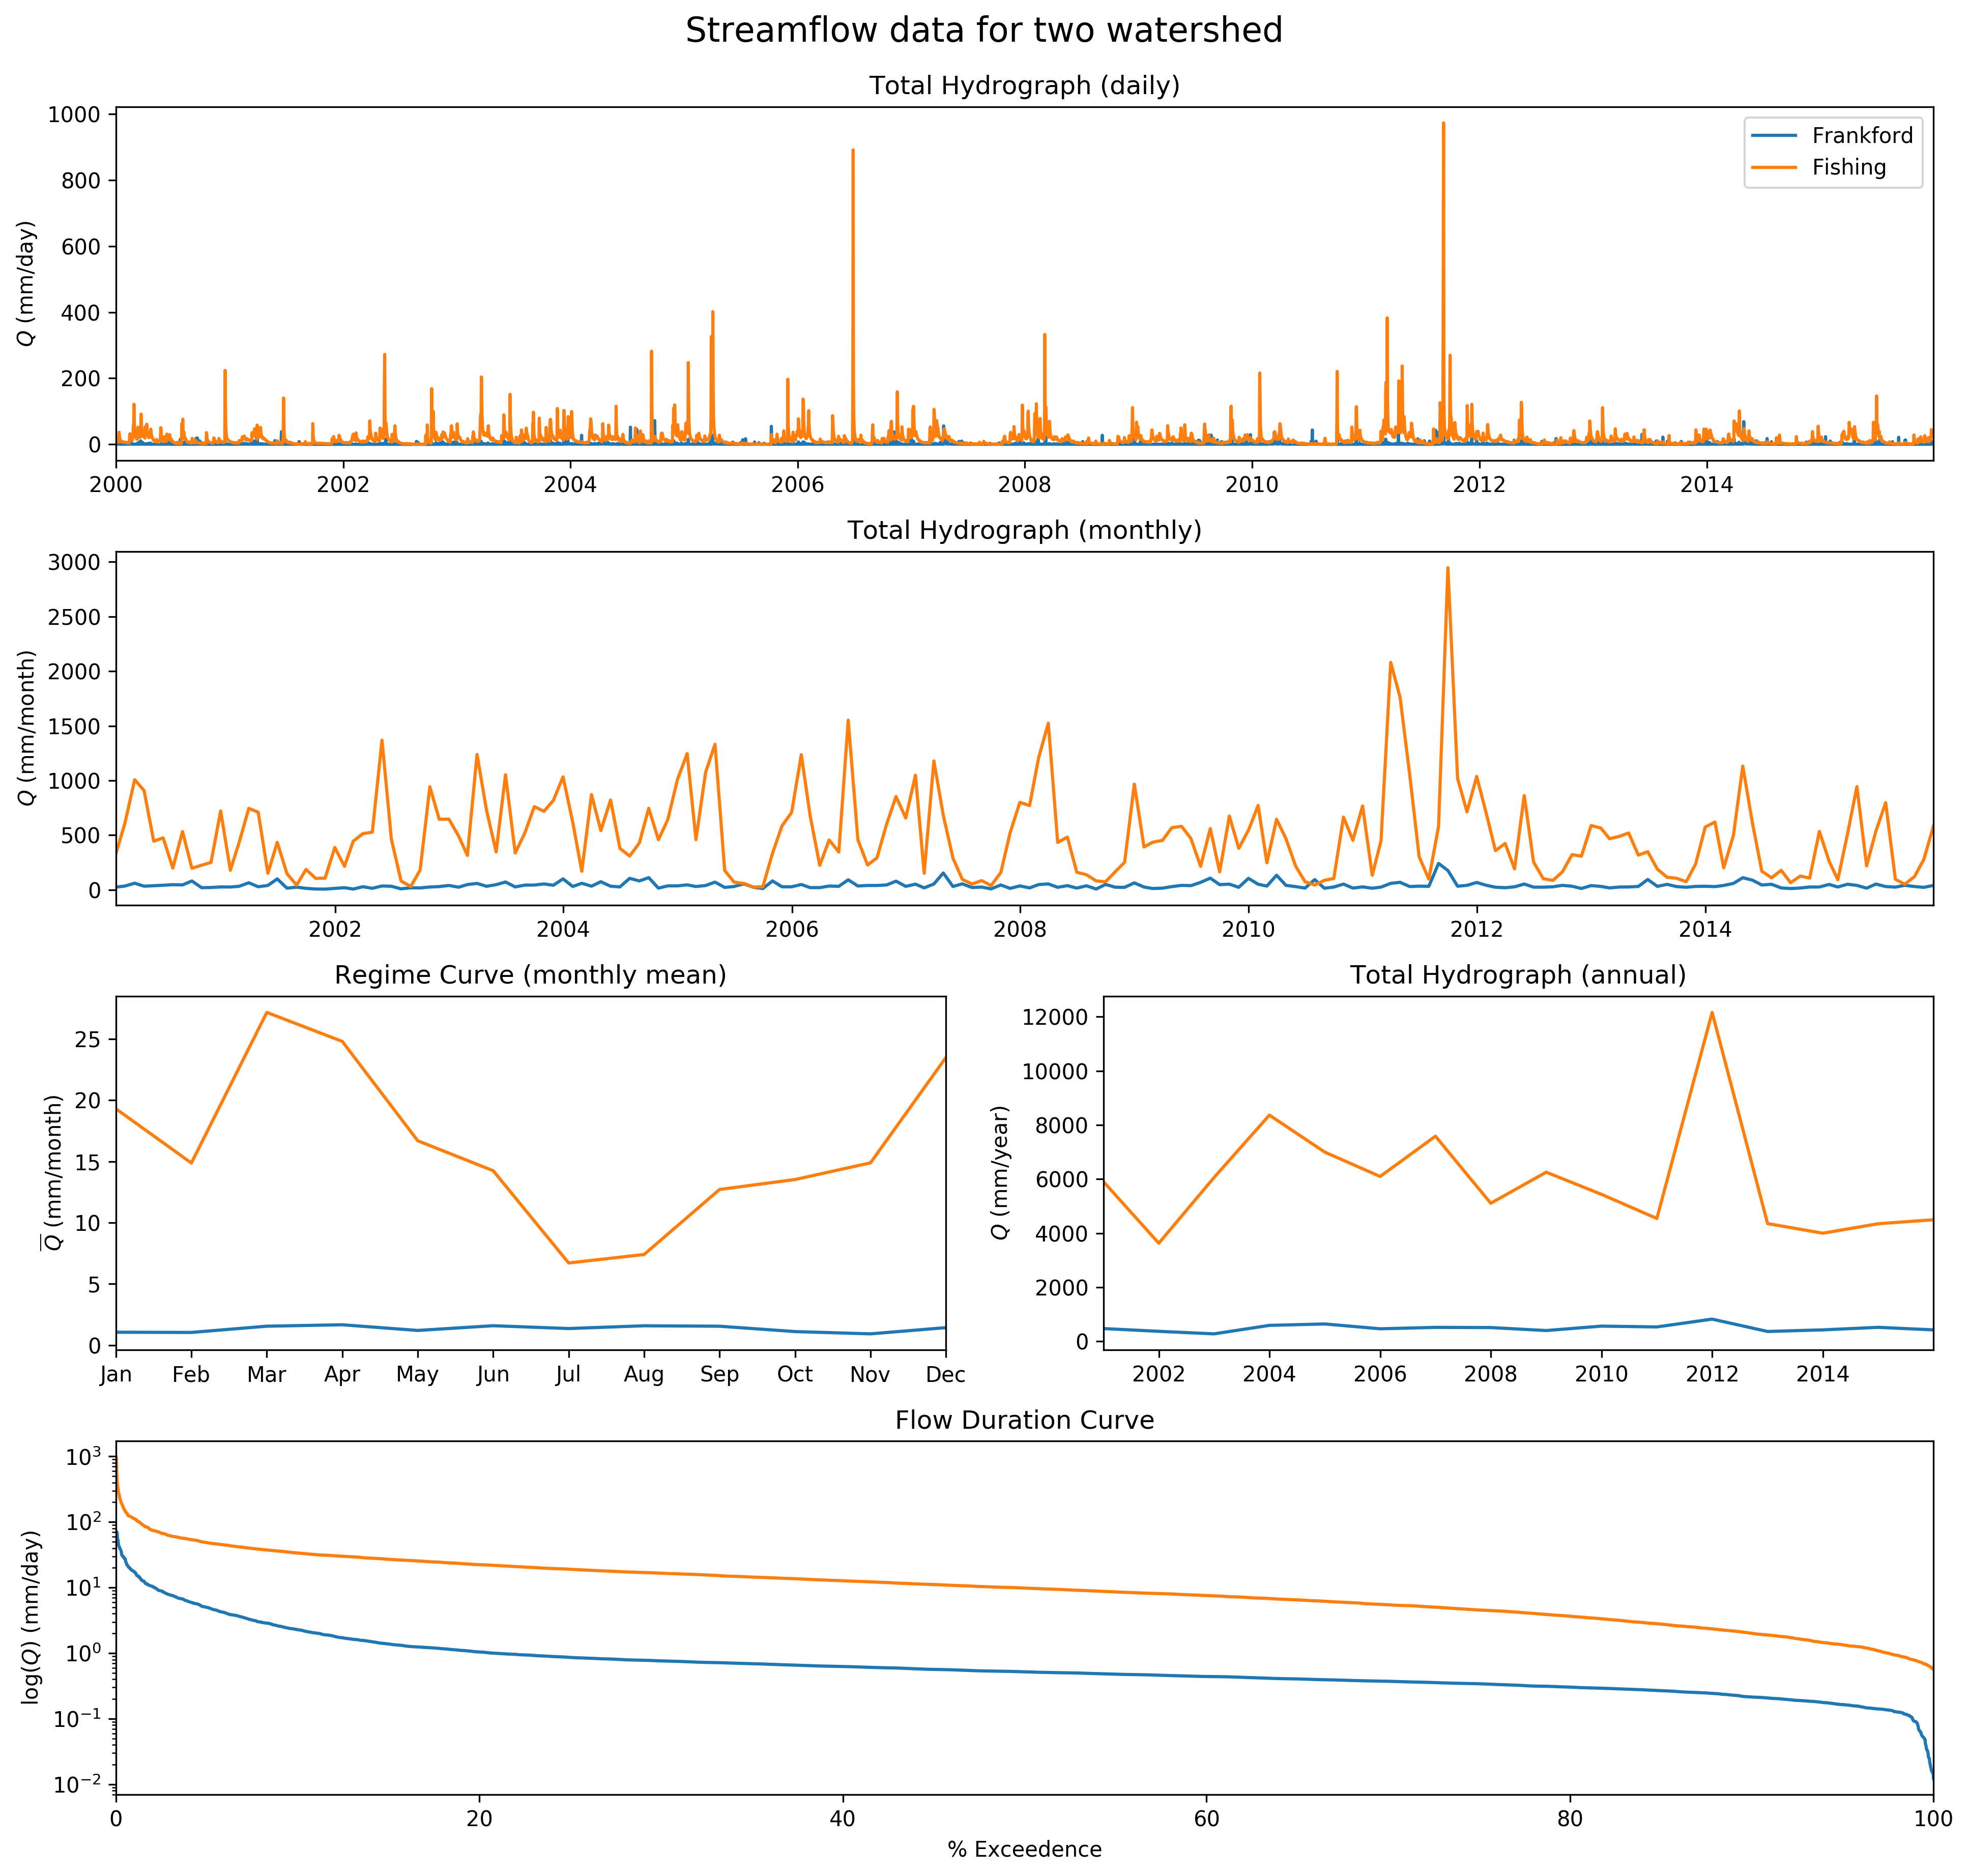

In [19]:
Q_dict = {'Frankford': frankford.climate['qobs (cms)'],
          'Fishing': fishing.climate['qobs (cms)']}
frankford.plot_discharge(Q_dict=Q_dict, title='Streamflow data for two watershed',
                         output=f'Discharges_{frankford.station_id}.png')